# Size density analysis

[...]

In [1]:
library(ggplot2)

These results have been obtained with the following command:
```bash
./size_density_runner.py --amalg --gcc --avx --cow --run\
    --size1 1:10000000 --size2 1:10000000\
    --density1 0.5 --density2 0.5 -n 100\
    size_results_cow_0.5.csv
```

Size of the two roaring bitmaps are sampled randomly and uniformly in [0, 10^7], their densities is 0.5, all optimizations are used.

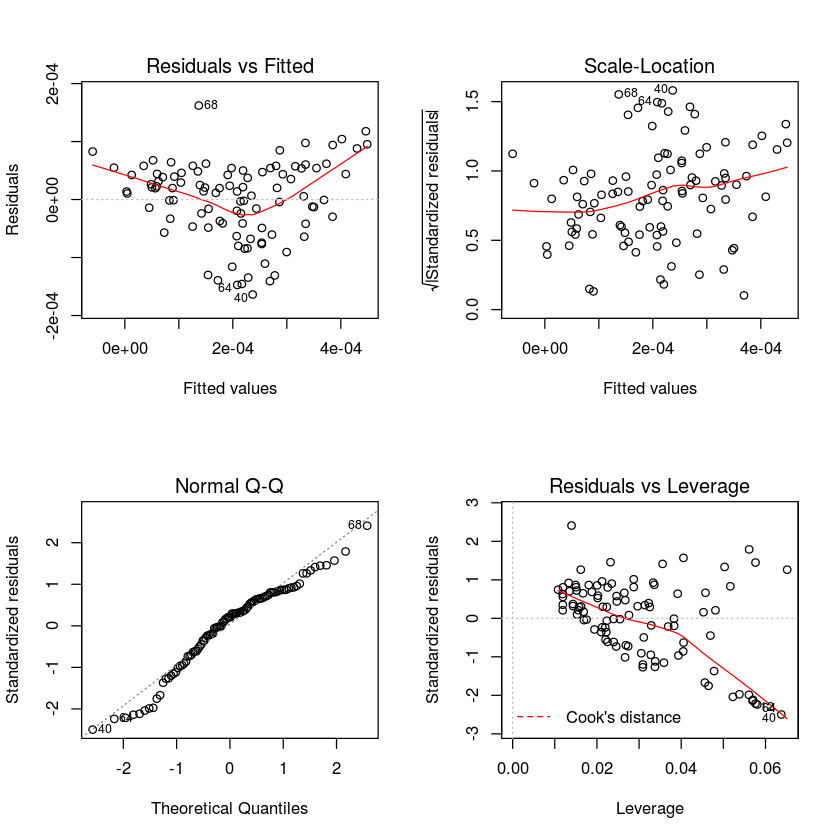

In [2]:
results_basic <- read.csv("size_results_cow_0.5.csv")
reg_basic <- lm(time~size1+size2, data=results_basic)
layout(matrix(c(1,2,3,4),2,2))
plot(reg_basic)

In [3]:
summary(reg_basic)


Call:
lm(formula = time ~ size1 + size2, data = results_basic)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.638e-04 -4.134e-05  1.408e-05  4.759e-05  1.621e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.873e-05  1.835e-05  -4.289 4.24e-05 ***
size1        2.657e-11  2.415e-12  11.005  < 2e-16 ***
size2        3.075e-11  2.522e-12  12.194  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.775e-05 on 97 degrees of freedom
Multiple R-squared:  0.741,	Adjusted R-squared:  0.7357 
F-statistic: 138.8 on 2 and 97 DF,  p-value: < 2.2e-16


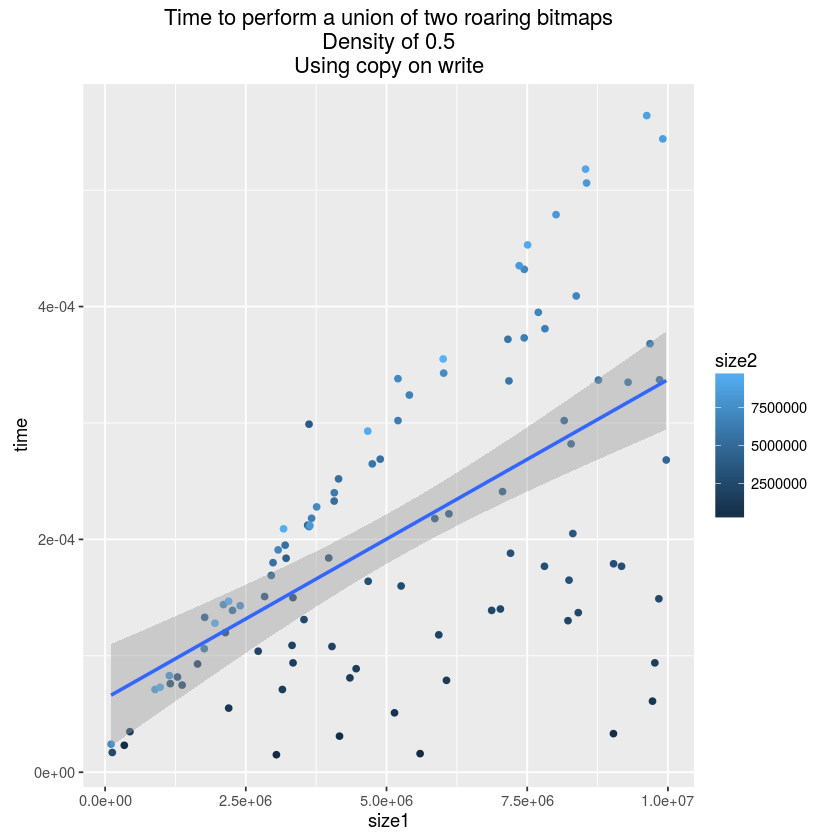

In [4]:
ggplot(results_basic, aes(x=size1, y=time, color=size2))+
    geom_point() + geom_smooth(method=lm) +
    ggtitle("Time to perform a union of two roaring bitmaps\nDensity of 0.5\nUsing copy on write")

It is clearly homoscedastic...

Hypothesis: it comes from copy on write.

Let's try without it!

These new results have been obtained with the following command:
```bash
./size_density_runner.py --amalg --gcc --avx --no-cow --run\
    --size1 1:10000000 --size2 1:10000000\
    --density1 0.5 --density2 0.5 -n 100\
    size_results_no_cow_0.5.csv
```

Size of the two roaring bitmaps are sampled randomly and uniformly in [0, 10^7], their densities is 0.5, all optimizations are used except copy on write.

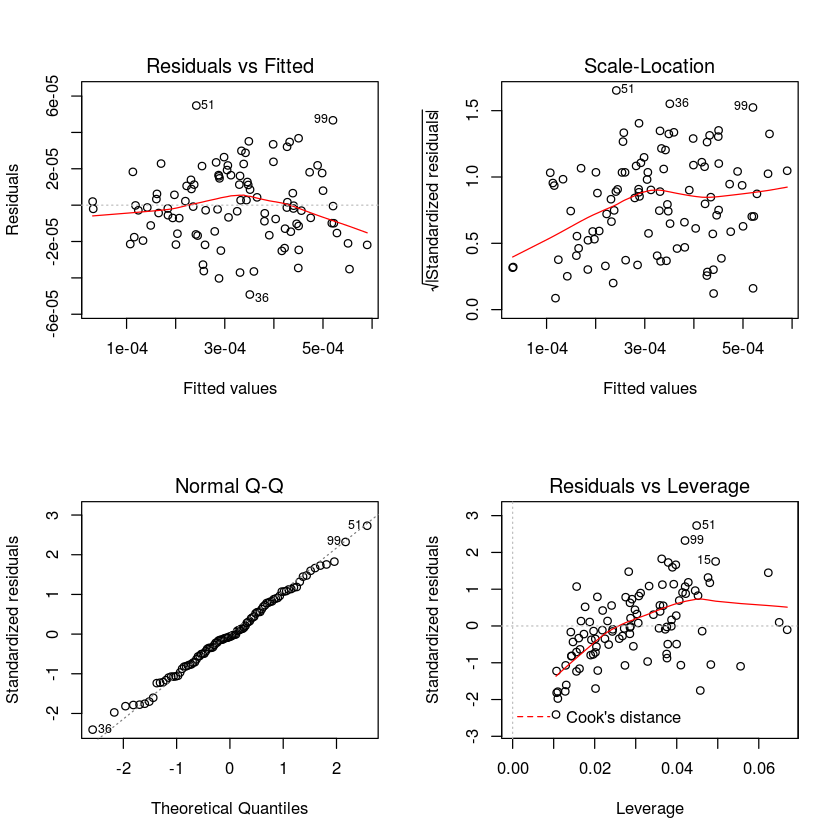

In [5]:
results_no_cow <- read.csv("size_results_no_cow_0.5.csv")
reg_no_cow <- lm(time~size1+size2, data=results_no_cow)
layout(matrix(c(1,2,3,4),2,2))
plot(reg_no_cow)

In [6]:
summary(reg_no_cow)


Call:
lm(formula = time ~ size1 + size2, data = results_no_cow)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.916e-05 -1.448e-05 -1.304e-06  1.501e-05  5.478e-05 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.415e-07  5.715e-06    0.13    0.897    
size1       2.900e-11  7.474e-13   38.80   <2e-16 ***
size2       3.430e-11  6.906e-13   49.67   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.053e-05 on 97 degrees of freedom
Multiple R-squared:  0.9747,	Adjusted R-squared:  0.9742 
F-statistic:  1868 on 2 and 97 DF,  p-value: < 2.2e-16


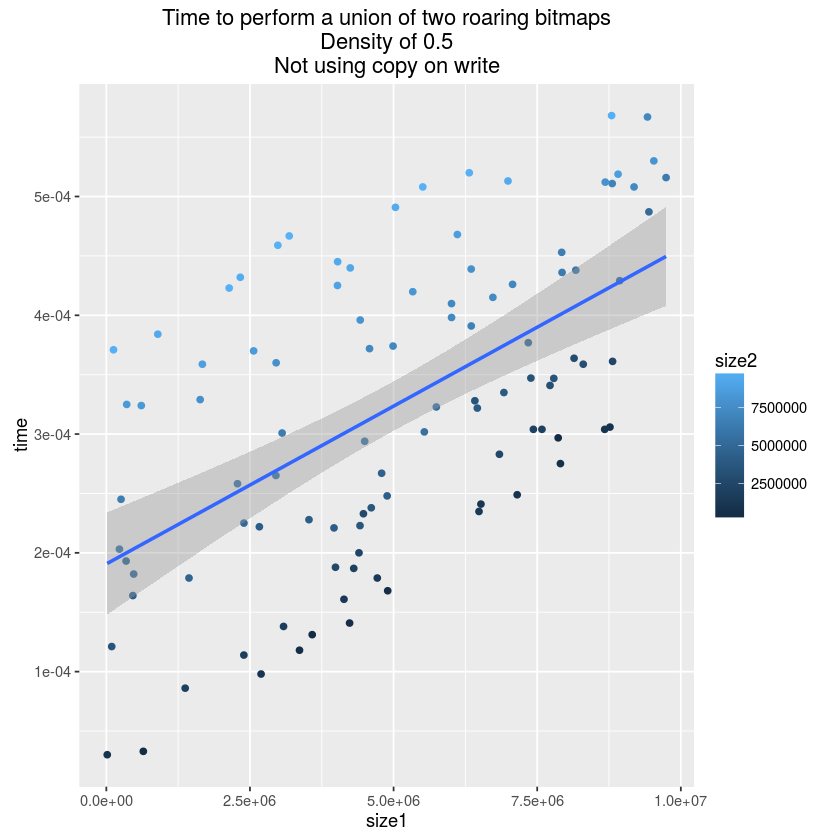

In [7]:
ggplot(results_no_cow, aes(x=size1, y=time, color=size2))+
    geom_point() + geom_smooth(method=lm) +
    ggtitle("Time to perform a union of two roaring bitmaps\nDensity of 0.5\nNot using copy on write")

Looks homoscedastic. But still a lot of noise, that is clearly due to the fact that the time also depends on `size2` and not only on `size1`.

We should try to agglomerate these two variables into a single one: let us take the sum.

In [8]:
results_no_cow$size_sum <- apply(results_no_cow[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max

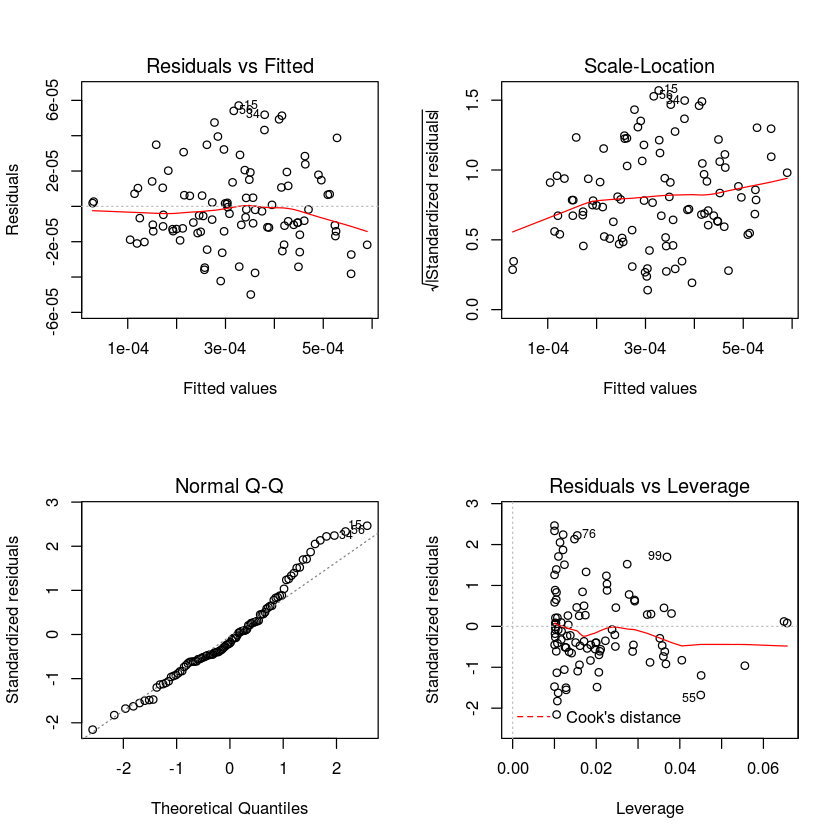

In [9]:
reg_no_cow2 <- lm(time~size_sum, data=results_no_cow)
layout(matrix(c(1,2,3,4),2,2))
plot(reg_no_cow2)

In [10]:
summary(reg_no_cow2)


Call:
lm(formula = time ~ size_sum, data = results_no_cow)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.990e-05 -1.410e-05 -4.468e-06  1.211e-05  5.707e-05 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.006e-06  6.469e-06  -0.156    0.877    
size_sum     3.188e-11  5.936e-13  53.698   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.327e-05 on 98 degrees of freedom
Multiple R-squared:  0.9671,	Adjusted R-squared:  0.9668 
F-statistic:  2883 on 1 and 98 DF,  p-value: < 2.2e-16


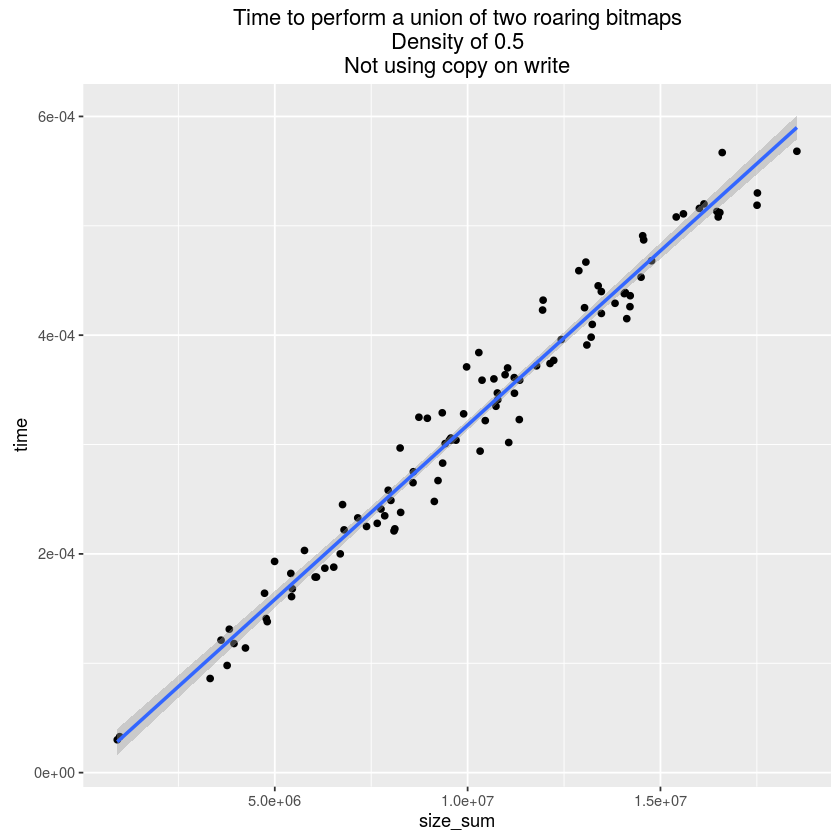

In [11]:
ggplot(results_no_cow, aes(x=size_sum, y=time))+
    geom_point() + geom_smooth(method=lm) +
    ggtitle("Time to perform a union of two roaring bitmaps\nDensity of 0.5\nNot using copy on write")

The plot still looks great, but with much less noise.

Let us see the impact of density.

The following results have been obtained with the command:
```bash
./size_density_runner.py --amalg --gcc --avx --no-cow --run\
    --size1 1:40000000 --size2 1:40000000\
    --density1 0.01,0.04,0.1,0.5,0.999\
    -n 434 results.csv # long, about 6h30 to run...
```

In [12]:
all_times = read.csv("size_density_results.csv")
all_times$density1 <- factor(all_times$density1)
all_times$size_sum <- apply(all_times[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max

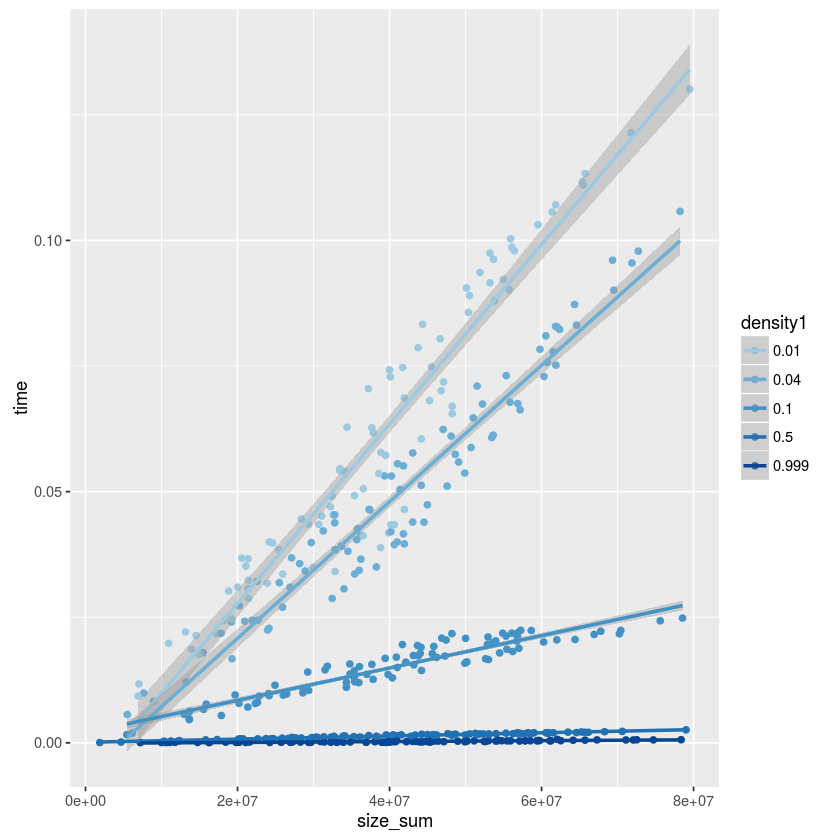

In [13]:
library(RColorBrewer)
my_colors = brewer.pal(n = 7, "Blues")[3:7] # we exclude the lightest colors

ggplot(all_times, aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            scale_colour_manual(values=my_colors)
            #scale_color_brewer(type="seq") # alternative, without excluding colors

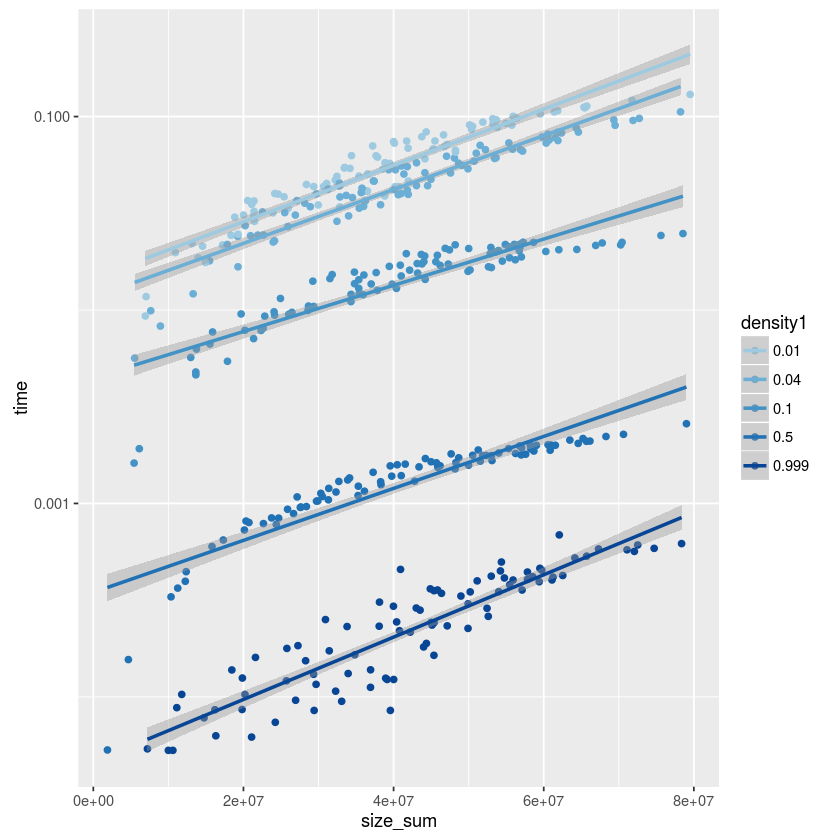

In [14]:
ggplot(all_times, aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            scale_colour_manual(values=my_colors) +
            scale_y_log10()

For the record, with Python 3, taking the union of two builtin sets containing 4\*10^7 elements each takes roughly 2.3s with a density of 0.5 and 4.8s with a density of 0.01. The memory consumption is also much higher (up to 8GB versus about 750 MB).

## TODO

* Why do we have similar standard errors and R-squared for the two last ones, although the last graph seems to have much less noise? Is it because these metrics highlight the extreme points (thanks to the square), which we still have?
* Add more talk. Explain what are roaring bitmaps, the basic principles. Explain more carefully the results we get. Also explain better the optimizations (in particular, the option run_containers: it does not allow or not run containers to be used (they may be used in both cases), it just triggers explicitely the function which checks if bitset or array containers should be converted to or from run containers).
